# Named Entity Recognition Menggunakan Tensorflow

Download package datasets dari library `Hugging Face`

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 10.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


Import library yang dibutuhkan

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, Bidirectional, LSTM, Dense
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt

## Load Dataset

Load dataset `conll2003` yang biasa dipakai untuk pembuatan model `Named Entity Recognition` dari `Hugging Face`

In [3]:
dataset = load_dataset("conll2003")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [4]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})


Mengelompokkan dataset menjadi Train, Validation dan Test

In [5]:
train_data = dataset['train']
val_data = dataset['validation']
test_data = dataset['test']

Parsing dataset Train menjadi `train_sentences` dan `train_labels`

In [6]:
train_sentences = [example['tokens'] for example in train_data]
train_labels = [np.array(example['ner_tags']) for example in train_data]

In [7]:
tag_maps = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}

print(f'Sentences: {train_sentences[0]}')
print(f'Labels: {train_labels[0]}\n')
print(f'Label information: {tag_maps}')

Sentences: ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
Labels: [3 0 7 0 0 0 7 0 0]

Label information: {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}


## Pre-processed Text

Membuat function `parsing_nested_list_to_list` untuk memparsing nested list menjadi list biasa, dan diubah formatnya menjadi numpy array. Function ini dibuat supaya bisa feed dataset kedalam layers `TextVectorization`

In [8]:
def parsing_nested_list_to_list(sentences):
  # Inisialisasi list kosong untuk menyimpan hasil pengolahan teks
  text_seq = []

  for sentence in sentences:
    # Menggabungkan setiap kata dalam kalimat menjadi satu string menggunakan ' '.join()
    text = ' '.join(sentence)
    # Menambahkan kalimat yang telah diproses ke dalam list text_seq
    text_seq.append(text)

  # Mereturn list text_seq yang telah dikonversi menjadi numpy array
  return np.array(text_seq)

In [9]:
train_sentences = parsing_nested_list_to_list(train_sentences)

In [10]:
print(f'Sentences: {train_sentences[0]}')
print(f'Data type: {type(train_sentences)}')

Sentences: EU rejects German call to boycott British lamb .
Data type: <class 'numpy.ndarray'>


Membuat function `get_sentence_vectorizer` yang memfeed dataset kedalam layers `TextVectorization`. Layers`TextVectorization` ini menghanlde tokenisasi dan vektorisasi dalam satu langkah agar mudah diintegrasikan kedalam arsitektur model.

In [11]:
def get_sentence_vectorizer(sentences):
  # Inisialisasi layers TextVectorization untuk vektorisasi kalimat
  sentence_vectorizer = TextVectorization(standardize = None)
  # Melatih vectorizer menggunakan data kalimat yang diberikan
  sentence_vectorizer.adapt(sentences)
  # Mendapatkan daftar kosakata dari vectorizer
  vocab = sentence_vectorizer.get_vocabulary()

  return sentence_vectorizer, vocab

In [12]:
sentence_vectorizer, vocab = get_sentence_vectorizer(train_sentences)

In [13]:
sentence = 'French is always be my favourite place to go'

sentence_vectorized = sentence_vectorizer(sentence)
print(f'Example sentences: {sentence}')
print(f'Vectorized Sentence: {sentence_vectorized.numpy()}')

Example sentences: French is always be my favourite place to go
Vectorized Sentence: [ 302   29 1192   40  445 6743  443    7  339]


Membuat function `padded_labels` untuk memberikan padding berdasarkan kalimat terpanjang agar memiliki panjang kalimat yang konsisten dan dapat difeed ke model saat proses training

In [14]:
def padded_labels(labels):
  # Menggunakan fungsi pad_sequences dari TensorFlow Keras untuk menyamakan panjang label/kalimat.
  # Parameter padding='post' digunakan untuk memastikan padding dilakukan setelah sequence.
  # Parameter value=-1 digunakan untuk menentukan nilai yang digunakan untuk padding.
  labels_ids = tf.keras.utils.pad_sequences(labels, padding='post', value=-1)

  return labels_ids

In [15]:
train_labels = padded_labels(train_labels)

In [16]:
print(f'Labels after padded: {train_labels[0]}')

Labels after padded: [ 3  0  7  0  0  0  7  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


Parsing dataset Validation menjadi `val_sentences` dan `val_labels` dan dataset Test menjadi `test_sentences` dan `test_labels`

In [17]:
val_sentences = [example['tokens'] for example in val_data]
val_labels = [np.array(example['ner_tags']) for example in val_data]
test_sentences = [example['tokens'] for example in test_data]
test_labels = [np.array(example['ner_tags']) for example in test_data]

In [18]:
val_sentences = parsing_nested_list_to_list(val_sentences)
val_labels = padded_labels(val_labels)
test_sentences = parsing_nested_list_to_list(test_sentences)
test_labels = padded_labels(test_labels)

Membuat function `generate_dataset` yang berfungsi untuk menjadi kan `sentences` dan `labels` menjadi satu kesatuan dataset

In [19]:
def generate_dataset(sentences, labels, sentence_vectorizer):
  # Menggunakan sentence_vectorizer untuk mengonversi kalimat yang dipass
  sentence_ids = sentence_vectorizer(sentences)
  # Membuat dataset TensorFlow dari tensor yang diberikan
  datasets = tf.data.Dataset.from_tensor_slices((sentence_ids, labels))

  return datasets

In [20]:
train_datasets = generate_dataset(train_sentences, train_labels, sentence_vectorizer)
val_datasets = generate_dataset(val_sentences, val_labels, sentence_vectorizer)
test_datasets = generate_dataset(test_sentences, test_labels, sentence_vectorizer)

In [21]:
print(f'Number of labels/outputs: {len(tag_maps)}')
print(f"Total vocabulary words in the training set: {len(vocab)}")
print(f'The training size: {len(train_datasets)}')
print(f'The validation size is: {len(val_datasets)}')
print('An example of the first sentence is\n\t', next(iter(train_datasets))[0].numpy())
print('An example of its corresponding label is\n\t', next(iter(train_datasets))[1].numpy())

Number of labels/outputs: 9
Total vocabulary words in the training set: 23625
The training size: 14041
The validation size is: 3250
An example of the first sentence is
	 [  994 13201   237   780     7  4476   212  6626     2     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0]
An example of its corresponding label is
	 [ 3  0  7  0  0  0  7  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 

## Build and Train Model

Membuat function `create_model` untuk membuat arsitektur model yang akan digunakan untuk proses training

In [51]:
def create_model(len_tags, vocab_size, embedding_dim=50):
  # Membuat model sequential
  model = tf.keras.Sequential()
  # Menambahkan layer embedding untuk mengkonversi token menjadi vektor embedding, mask_zero=True artinya nilai 0 akan diabaikan
  # Kita perlu menambahkan 1 di input_dim, karena sekarang Tensorflow akan mempertimbangkan bahwa satu nilai tambahan 0 mungkin muncul di setiap kalimat.
  model.add(Embedding(input_dim=vocab_size+1, output_dim=embedding_dim, mask_zero=True))
  # Menambahkan layer LSTM dua arah dengan 64 unit, menghasilkan output untuk setiap timestep dalam urutan
  model.add(Bidirectional(LSTM(32, return_sequences=True)))
  # Menambahkan layer Dense untuk melakukan klasifikasi, dengan jumlah unit sama dengan jumlah tag, menggunakan fungsi aktivasi log_softmax
  model.add(Dense(len_tags, activation=tf.nn.log_softmax))

  return model

In [23]:
model = create_model(len(tag_maps), len(vocab))

Melihat ringkasan arsitektur model

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          1181300   
                                                                 
 bidirectional (Bidirection  (None, None, 64)          21248     
 al)                                                             
                                                                 
 dense (Dense)               (None, None, 9)           585       
                                                                 
Total params: 1203133 (4.59 MB)
Trainable params: 1203133 (4.59 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Membuat function `masked_loss` yang merupakan implementasi dari perhitungan loss `SparseCategoricalCrossentropy` untuk klasifikasi multikelas yang juga memperhitungkan mask atau pengabaian untuk padding/kelas tertentu. Ini memungkinkan untuk mengontrol bagaimana loss dihitung

In [25]:
def masked_loss(y_true, y_pred):
  # Mendefinisikan fungsi kerugian dengan SparseCategoricalCrossentropy
  # Parameter from_logits=True menunjukkan pada loss function bahwa nilai output yang dihasilkan oleh model tidak dinormalisasi, alias logit.
  # Dengan kata lain, fungsi softmax belum diterapkan pada mereka untuk menghasilkan distribusi probabilitas.
  # Oleh karena itu, lapisan output dalam kasus ini tidak memiliki fungsi aktivasi softmax:
  # ignore_class=-1 mengabaikan kelas dengan nilai -1 saat menghitung kerugian
  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, ignore_class=-1)

  # Menghitung kerugian menggunakan fungsi kerugian yang telah didefinisikan
  loss = loss_fn(y_true, y_pred)

  return loss

Membuat function `masked_accuracy` yang menghasilkan nilai akurasi yang memperhitungkan hanya prediksi yang relevan dengan label yang tidak di-mask (-1 diabaikan). Ini berguna ketika ada label yang harus diabaikan dalam perhitungan akurasi, seperti dalam kasus pemrosesan teks dengan token khusus yang perlu diabaikan.

In [26]:
def masked_accuracy(y_true, y_pred):
  # Mengonversi tensor label sebenarnya ke tipe data float32
  y_true = tf.cast(y_true, tf.float32)

  # Membuat masker untuk nilai yang akan diabaikan yaitu -1 dan mengonversi ke tipe data float32
  mask = tf.not_equal(y_true, -1)
  mask = tf.cast(mask, tf.float32)

  # Menerapkan argmax untuk mendapatkan nilai prediksi, dan mengonversi ke tipe data float32
  y_pred_class = tf.math.argmax(y_pred, axis=-1)
  y_pred_class = tf.cast(y_pred_class, tf.float32)

  # Membandingkan label sebenarnya dengan kelas prediksi, dan mengonversi ke tipe data float32
  matches_true_pred  = tf.equal(y_true, y_pred_class)
  matches_true_pred = tf.cast(matches_true_pred, tf.float32)

  # Mengalikan hasil perbandingan dengan masker, sehingga hanya menghitung akurasi untuk label yang tidak di-mask
  matches_true_pred *= mask

  # Menghitung akurasi dengan jumlah prediksi yang benar dibagi dengan jumlah label yang tidak di-mask
  masked_acc = tf.reduce_sum(matches_true_pred) / tf.reduce_sum(mask)

  return masked_acc

Menentukan compiler model untuk training

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=masked_loss,
              metrics=[masked_accuracy])

Membuat callback yang akan otomatis menyimpan model dengan`val_loss` dengan weights paling rendah

In [28]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Training model

In [29]:
BATCH_SIZE = 64

history = model.fit(train_datasets.batch(BATCH_SIZE),
          validation_data = val_datasets.batch(BATCH_SIZE),
          shuffle=True,
          epochs=5,
          callbacks=[early_stopping])

Epoch 1/5
220/220 [==============================] - 70s 255ms/step - loss: 0.4786 - masked_accuracy: 0.8797 - val_loss: 0.1838 - val_masked_accuracy: 0.9486
Epoch 2/5
220/220 [==============================] - 52s 235ms/step - loss: 0.0817 - masked_accuracy: 0.9778 - val_loss: 0.1418 - val_masked_accuracy: 0.9600
Epoch 3/5
220/220 [==============================] - 47s 213ms/step - loss: 0.0279 - masked_accuracy: 0.9923 - val_loss: 0.1508 - val_masked_accuracy: 0.9619
Epoch 4/5
220/220 [==============================] - 39s 177ms/step - loss: 0.0124 - masked_accuracy: 0.9966 - val_loss: 0.1565 - val_masked_accuracy: 0.9625
Epoch 5/5
220/220 [==============================] - 41s 185ms/step - loss: 0.0062 - masked_accuracy: 0.9984 - val_loss: 0.1742 - val_masked_accuracy: 0.9625


## Evaluate Model

Membuat function `create_plot` untuk plot akurasi dan loss pada saat training model

In [30]:
def create_plot(history, string):
  # Plot training loss atau accuracy.
  plt.plot(history.history[string], 'r', label='Training '+string)
  # Plot validation loss atau accuracy.
  plt.plot(history.history['val_'+string], 'b', label='Validation '+string)
  # Set judul plot.
  plt.title('Training and validation '+string)
  # Tampilkan legenda.
  plt.legend()
  # Tampilkan plot.
  plt.show()
  # Tampilkan baris kosong untuk pemisah.
  print('')

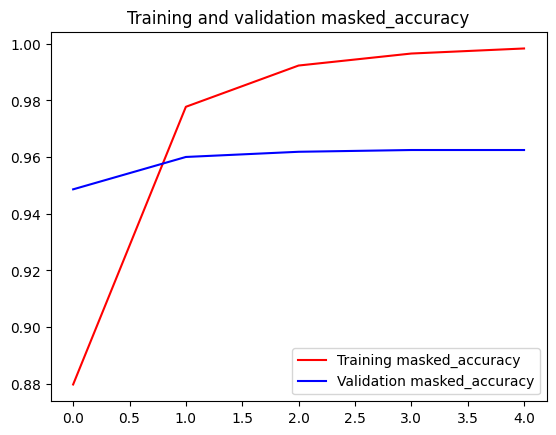

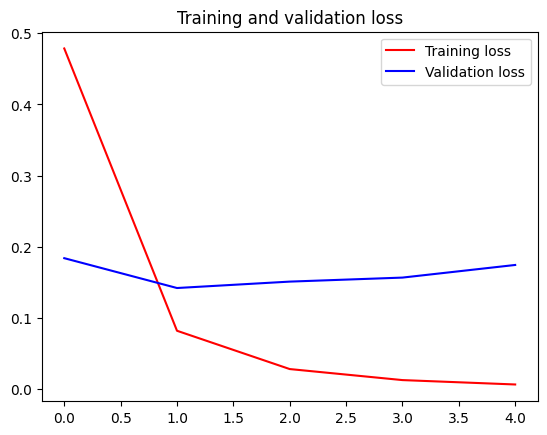

In [31]:
create_plot(history, 'masked_accuracy')
create_plot(history, 'loss')

Evaluasi model menggunakan dataset test

In [32]:
evaluation_test = model.evaluate(test_datasets.batch(BATCH_SIZE))

print(f'\nThe model loss on test dataset: {evaluation_test[0]}')
print(f'The model accuracy on test dataset: {evaluation_test[1]}')

54/54 [==============================] - 5s 40ms/step - loss: 0.2401 - masked_accuracy: 0.9388

The model loss on test dataset: 0.2400500327348709
The model accuracy on test dataset: 0.9387746453285217


Cara lain untuk mengevaluasi model dengan data testing

In [33]:
'''
test_sentences_ids = sentence_vectorizer(test_sentences)
y_true = test_labels
y_pred = model.predict(test_sentences_ids)
print(f'The model loss on test set is: {masked_loss(y_true,y_pred).numpy():.4f}')
print(f'The model accuracy on test set is: {masked_accuracy(y_true,y_pred).numpy():.4f}')
'''

"\ntest_sentences_ids = sentence_vectorizer(test_sentences)\ny_true = test_labels\ny_pred = model.predict(test_sentences_ids)\nprint(f'The model loss on test set is: {masked_loss(y_true,y_pred).numpy():.4f}')\nprint(f'The model accuracy on test set is: {masked_accuracy(y_true,y_pred).numpy():.4f}')\n"

Note : Jika ingin mendapat hasil loss yang sama saat running kedua metode evaluasi model dengan test dataset diatas, maka ukuran batchnya harus sama, karena jika tidak lossnya akan memiliki hasil yang berbeda

Membuat function `predict` yang akan fed input text ke model yang telah ditraining dan menghasilkan prediksi

In [49]:
def predict(sentence, model, sentence_vectorizer, tag_map):
    # Mengonversi kalimat menjadi vektor fitur dengan menggunakan sentence_vectorizer
    sentence_vectorized = sentence_vectorizer(sentence)
    # Menambahkan dimensi tambahan pada vektor fitur untuk sesuai untuk di fed ke model
    sentence_vectorized = tf.expand_dims(sentence_vectorized, 0)
    # Melakukan prediksi menggunakan model NER
    outputs = model(sentence_vectorized)
    # Dapatkan label yang diprediksi untuk setiap token, menggunakan fungsi argmax dan menentukan axis yang benar untuk melakukan argmax
    output = np.argmax(outputs, axis=-1)
    # Baris berikutnya hanya untuk menyesuaikan dimensi keluaran. Karena fungsi ini hanya mengharapkan satu masukan untuk mendapatkan prediksi, keluarannya akan menjadi seperti [[1,2,3]]
    # jadi untuk menghindari notasi yang berat di bawah ini, mari kita ubah menjadi [1,2,3]
    output = output[0]
    # Mendapatkan daftar label yang sesuai dengan tag_map
    labels = list(tag_map.keys())
    pred = []
    # Iterasi melalui setiap indeks label hasil prediksi
    for tag_idx in output:
        pred_label = labels[tag_idx]
        pred.append(pred_label)

    return pred

In [50]:
sentence = "John Smith works at Microsoft in Washington DC"
predictions = predict(sentence, model, sentence_vectorizer, tag_maps)
for x,y in zip(sentence.split(' '), predictions):
    if y != 'O':
        print(f'{x} --> {y}')

John --> B-PER
Smith --> I-PER
Microsoft --> B-ORG
Washington --> B-LOC
DC --> I-LOC


Menyimpan file txt yang berisi tentang vektorisasi kalimat yang telah diproses dengan layer `TextVectorization`. Hasil dari `TextVectorization` disimpan agar bisa digunakan kembali saat deployment menggunakan flask/streamlit.

In [38]:
import os

folder_path = 'vectorizer'
file_name = 'vocabulary.txt'
file_path = os.path.join(folder_path, file_name)

if not os.path.exists(folder_path):
  os.mkdir(folder_path)

  if not os.path.exists(file_path):
    with open(file_path, 'w') as v:
      pass

    sentence_vectorizer.save_assets(folder_path)
    print('File vectorizer berhasil disimpan')
  else:
    print(f'File {file_name} sudah ada')

else:
  print(f'Folder {folder_path} sudah ada')

File vectorizer berhasil disimpan


Menyimpan model yang telah ditraining

In [39]:
model.save('NER model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
